# Sheet 03

In [136]:
import numpy as np
import cv2 as cv
import random
from matplotlib import pyplot as plt

## 1. Hough Transform for Line Detection

Given the image shapes.png of different shapes, read the image and convert it into a grayscale image.

(a) Detect the lines by a Hough transform using cv2.HoughLines. Visualize the detections by drawing lines on the image.

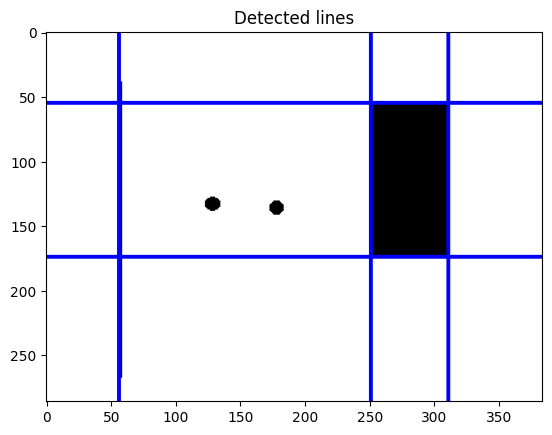

In [137]:
img = cv.imread('./images/shapes.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray, 40, 80)

lines = cv.HoughLines(edges, 1, np.pi/90, 50)
for line in lines:
    d, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*d
    y0 = b*d
    x1 = int(x0 + np.linalg.norm(img.shape)*(-b))
    y1 = int(y0 + np.linalg.norm(img.shape)*a)
    x2 = int(x0 - np.linalg.norm(img.shape)*(-b))
    y2 = int(y0 - np.linalg.norm(img.shape)*a)

    cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

_ = plt.imshow(img)
_ = plt.title('Detected lines')

(b) Detect the lines with your implementation of myHoughLines. Visualize the detections and the accumulator.

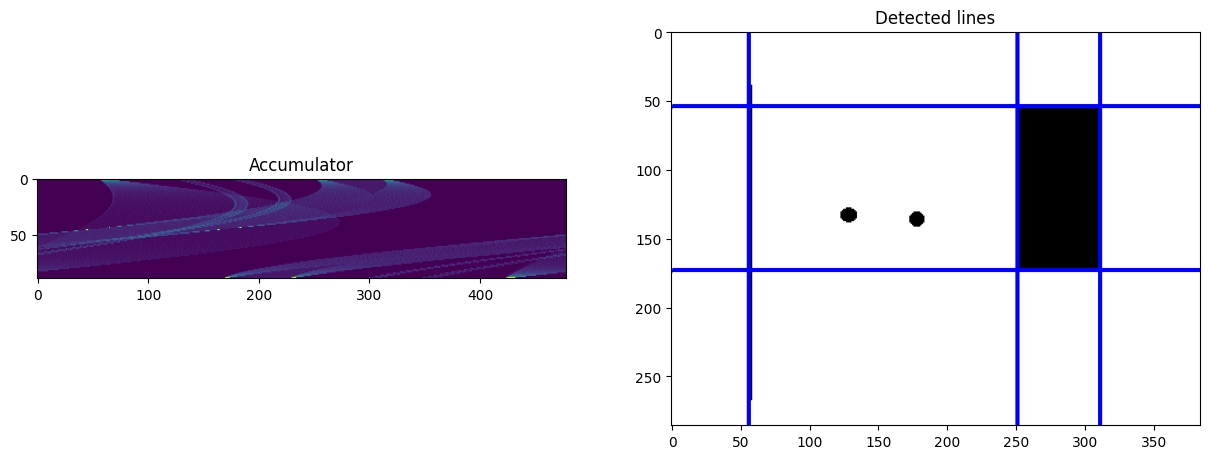

In [138]:
def myHoughLines(img_edges, d_resolution, theta_step_sz, threshold):
    """
    Your implementation of HoughLines
    :param img_edges: single-channel binary source image (e.g: edges)
    :param d_resolution: the resolution for the distance parameter
    :param theta_step_sz: the resolution for the angle parameter
    :param threshold: minimum number of votes to consider a detection
    :return: list of detected lines as (d, theta) pairs and the accumulator
    """
    accumulator = np.zeros((int(180/theta_step_sz), int(np.linalg.norm(img_edges.shape)/d_resolution)))
    edges_points = np.array(np.nonzero(img_edges))

    for i in range(edges_points.shape[1]):
        for theta in range(0, 180, theta_step_sz):
            d = int((edges_points[1][i] * np.cos(theta*np.pi/180.) + edges_points[0][i] * np.sin(theta*np.pi/180.)) / d_resolution)
            accumulator[int(theta/theta_step_sz), d] += 1
    
    accumulator_copy = accumulator
    detected_lines = []
    finished = False
    while not finished:
        idx = np.argmax(accumulator_copy)
        theta, d = np.unravel_index(idx, accumulator_copy.shape)

        if accumulator_copy[theta, d] > threshold:
            detected_lines.append([d * d_resolution, theta * theta_step_sz * np.pi / 180.])
        else:
            finished = True

        accumulator_copy[theta, d] = 0

    return detected_lines, accumulator


img = cv.imread('./images/shapes.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray, 40, 80)

detected_lines, accumulator = myHoughLines(edges, 1, 2, 50)

for line in detected_lines:
    d, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*d
    y0 = b*d
    x1 = int(x0 + np.linalg.norm(img.shape)*(-b))
    y1 = int(y0 + np.linalg.norm(img.shape)*a)
    x2 = int(x0 - np.linalg.norm(img.shape)*(-b))
    y2 = int(y0 - np.linalg.norm(img.shape)*a)

    cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

accumulator = 255*(accumulator-np.min(accumulator))/float(np.max(accumulator)-np.min(accumulator))
accumulator = np.uint8(np.round(accumulator))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
_ = plt.imshow(accumulator)
_ = plt.title('Accumulator')
plt.subplot(1,2,2)
_ = plt.imshow(img)
_ = plt.title('Detected lines')

## 3. K-Means for Segmentation as Clustering
Implement the function myKmeans and then use it to segment the image flower.png
based on:

(a) Intensity

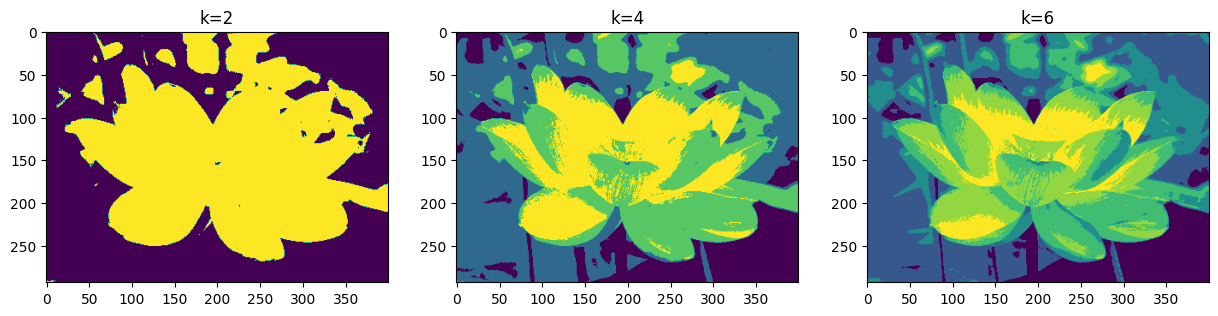

In [139]:
def myKmeans(data, k):
    """
    Your implementation of k-means algorithm
    :param data: list of data points to cluster
    :param k: number of clusters
    :return: centers and list of indices that store the cluster index for each data point
    """
    centers = np.zeros((k, data.shape[1]))
    index = np.zeros(data.shape[0], dtype=int)
    clusters = [[] for i in range(k)]

    # random centers initialization
    for i in range(k):
        centers[i] = data[random.randint(0, data.shape[0] - 1)]

    convergence = False
    while not convergence:
        convergence = True
        for i in range(k):
            clusters[i] = []

        # assign each point to the cluster of closest center
        distances = np.linalg.norm(data[:, None, :] - centers[None, :, :], axis=-1)
        index = np.argmin(distances, axis=-1)
        for i in range(len(data)):
            clusters[index[i]].append(data[i])
    
        # update clusters' centers
        for i in range(k):
            if len(clusters[i]) != 0:
                c = sum(clusters[i]) / float(len(clusters[i]))
                if np.linalg.norm(c - centers[i]) > 2:
                    convergence = False
                centers[i] = c

    return index, centers


img = cv.imread('./images/flower.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

data = img_gray.reshape((-1, 1))
data = np.float32(data)
plt.figure(figsize=(15,15))
i = 1
for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img_gray.shape))

    plt.subplot(1,3,i)
    _ = plt.imshow(res2)
    _ = plt.title('k='+str(k))
    i += 1

(b) Color

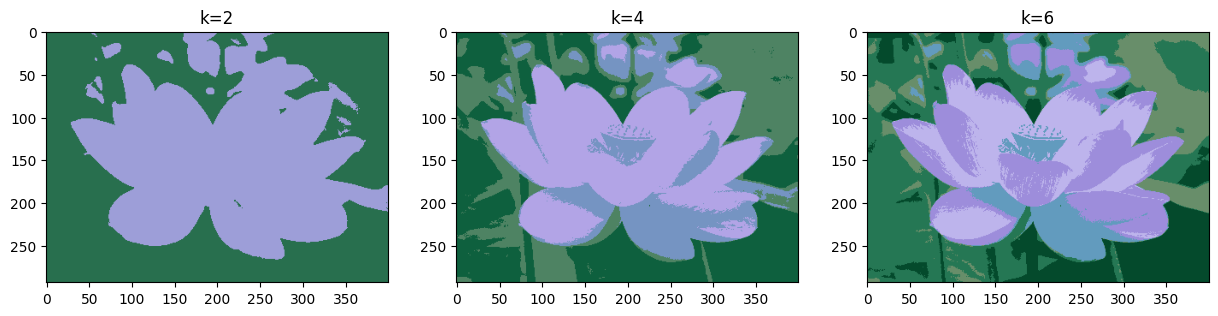

In [140]:
img = cv.imread('./images/flower.png')

data = img.reshape((-1, 3))
data = np.float32(data)
plt.figure(figsize=(15,15))
i=1
for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    plt.subplot(1,3,i)
    _ = plt.imshow(res2)
    _ = plt.title('k='+str(k))
    i += 1

(c) Intensity and (properly scaled) image position

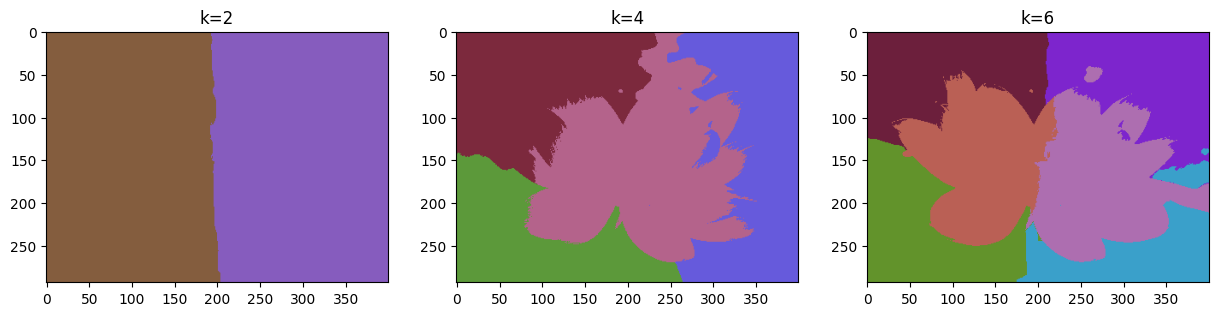

In [141]:
img = cv.imread('./images/flower.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

pos = np.indices(img_gray.shape).transpose(1, 2, 0).reshape(-1, 2)
pos = np.float32(pos * 255. / np.max(pos))

data = img_gray.reshape((-1, 1))
data = np.float32(data)
data = np.concatenate((data, pos), axis=1)
plt.figure(figsize=(15,15))
i=1
for k in [2, 4, 6]:
    label, center = myKmeans(data, k)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    plt.subplot(1,3,i)
    _ = plt.imshow(res2)
    _ = plt.title('k='+str(k))
    i += 1

(d) Other property that you choose as the feature space. 

## 4. Mean Shift

Implement the function meanShift and use it to:

(a) Find the peaks in the accumulator. You should read the image line.png and use your implementation of myHoughLines in Question 1 (b) to get the accumulator of the detected lines in the image. Visualize the accumulator and the lines corresponding to the peaks.

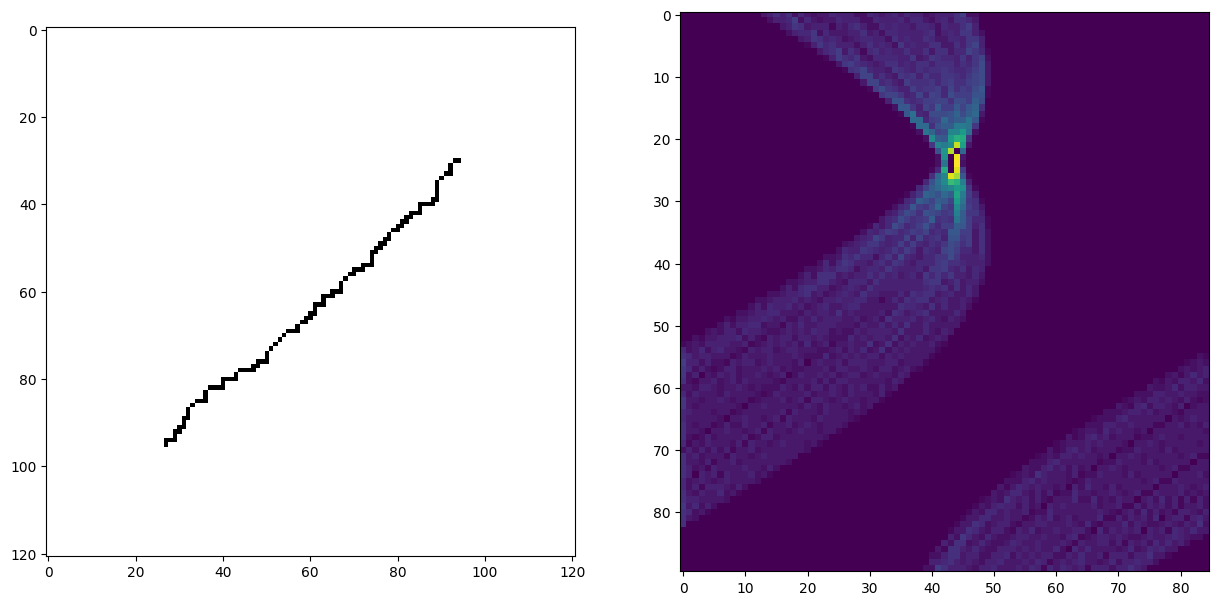

In [142]:
img = cv.imread('./images/line.png')
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
edges = cv.Canny(img_gray, 40, 50)
theta_res = 2
d_res = 2
_, accumulator = myHoughLines(edges, d_res, theta_res, 50)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
_ = plt.imshow(img)
plt.subplot(1,2,2)
_ = plt.imshow(accumulator)

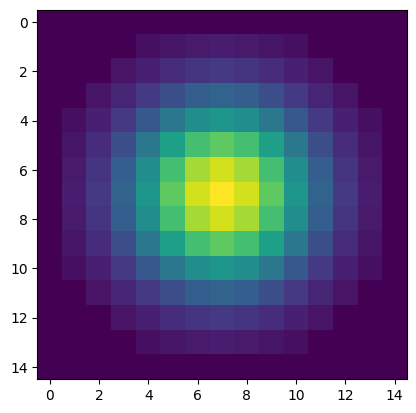

In [143]:
def createMask(window_size):
    mask = np.zeros((2 * window_size + 1, 2 * window_size + 1))
    center = (window_size, window_size)
    for i in range(2 * window_size + 1):
        for j in range(2 * window_size + 1):
            if np.linalg.norm([i - center[0], j - center[1]]) < window_size:
                mask[i, j] = np.exp(-(np.linalg.norm([i - center[0], j - center[1]])**2) / (2.*window_size))
    return mask

window_size = 7
mask = createMask(window_size)

_ = plt.imshow(mask)

15 peaks found:  [[51, 24], [50, 25], [51, 25], [50, 26], [51, 27], [50, 28], [50, 30], [50, 32], [50, 33], [50, 34], [50, 35], [49, 36], [49, 37], [50, 37], [51, 37]]


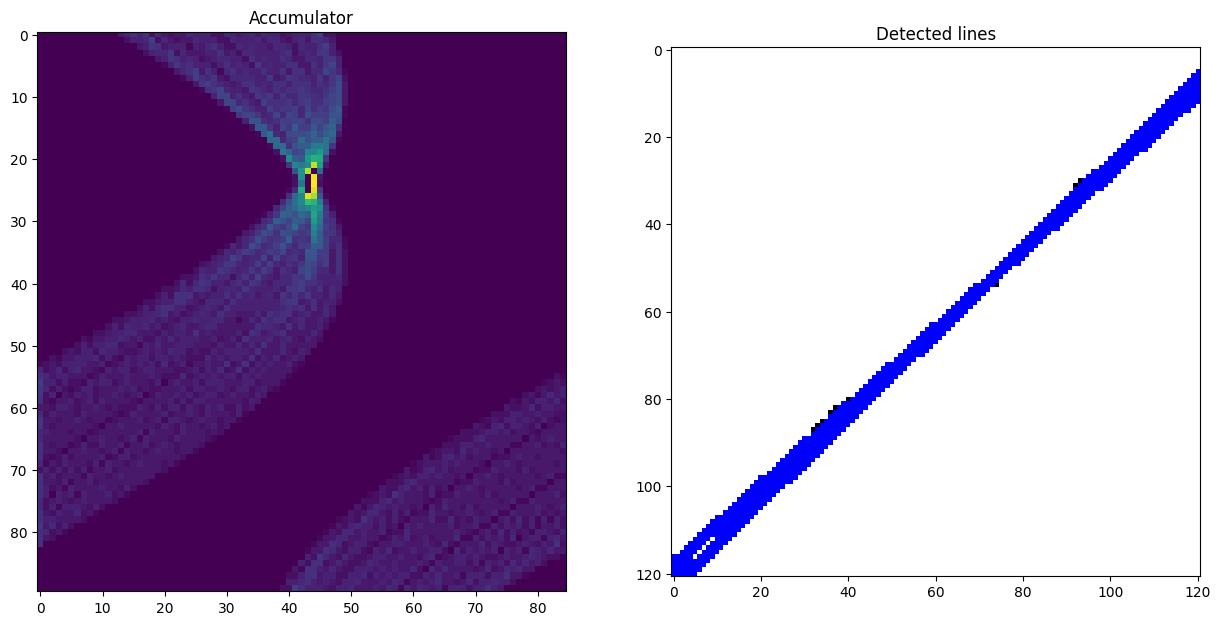

In [144]:
def meanShift(padded_acc, window_size, mask, x1, y1):
    # 2D
    
    conveged = False
    idx = 0
    while not conveged and idx < (padded_acc.shape[1]+padded_acc.shape[0]):
        idx += 1
        sum_w = np.sum(mask * padded_acc[y1-window_size:y1+window_size+1, x1-window_size:x1+window_size+1])
        sum_x = np.sum(np.arange(x1-window_size, x1+window_size+1) * mask * padded_acc[y1-window_size:y1+window_size+1, \
                                                                             x1-window_size:x1+window_size+1])
        sum_y = np.sum(np.arange(y1-window_size, y1+window_size+1)[:, None] * mask * padded_acc[y1-window_size:y1+window_size+1, \
                                                                                      x1-window_size:x1+window_size+1])

        x2 = sum_x / sum_w
        y2 = sum_y / sum_w
 
        if np.linalg.norm([x2 - x1, y2 - y1]) < 0.1:
            conveged = True
        else:
            x1 = int(round(x2))
            y1 = int(round(y2))
    return x2, y2, sum_w

padded_acc = np.zeros((accumulator.shape[0] + 2 * window_size, accumulator.shape[1] + 2 * window_size))
padded_acc[window_size:window_size+accumulator.shape[0], window_size:window_size+accumulator.shape[1]] = accumulator
threshold = 400
peaks = []

votes_i, votes_j = np.nonzero(padded_acc)
for idx in range(0, len(votes_i), window_size):
    y1 = votes_i[idx]
    x1 = votes_j[idx]
    x2, y2, sum_w = meanShift(padded_acc, window_size, mask, x1, y1)
    
    if sum_w > threshold:
        x2 = int(round(x2))
        y2 = int(round(y2))
        if [x2, y2] not in peaks:
            peaks.append([x2, y2])
            
pruned_peaks = []
for p in peaks:
    neighbors = padded_acc[p[1] - window_size: p[1] + window_size, p[0] - window_size: p[0] + window_size]
    y, x = np.unravel_index(np.argmax(neighbors, axis=None), neighbors.shape)
    if [x - 2 * window_size + p[0], y - 2 * window_size + p[1]] not in pruned_peaks:
        pruned_peaks.append([x - 2 * window_size + p[0], y - 2 * window_size + p[1]])
print("%d peaks found: " % len(peaks), peaks)


for line in pruned_peaks:
    d, theta = line
    theta = theta * theta_res * np.pi / 180.
    d = d * d_res
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * d
    y0 = b * d
    x1 = int(x0 + np.linalg.norm(img.shape) * (-b))
    y1 = int(y0 + np.linalg.norm(img.shape) * a)
    x2 = int(x0 - np.linalg.norm(img.shape) * (-b))
    y2 = int(y0 - np.linalg.norm(img.shape) * a)

    cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

acc = 255 * (accumulator - np.min(accumulator)) / float(np.max(accumulator) - np.min(accumulator))
acc = np.uint8(np.round(acc))


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
_ = plt.imshow(accumulator)
_ = plt.title('Accumulator')
plt.subplot(1,2,2)
_ = plt.imshow(img)
_ = plt.title('Detected lines')

(b) Segment the image flower.png in Question 3. Compare the results with K-Means.